*This code sets up and trains a LightGBM (LGBM) model to predict stock market performance using historical stock data*

Fold 0 started at Wed May 29 07:55:19 2024
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Info] Number of positive: 3055, number of negative: 53031
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15822
[LightGBM] [Info] Number of data points in the train set: 56086, number of used features: 72
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.054470 -> initscore=-2.854097
[LightGBM] [Info] Start training from score -2.854097
[LightGBM] [Warning] No further s

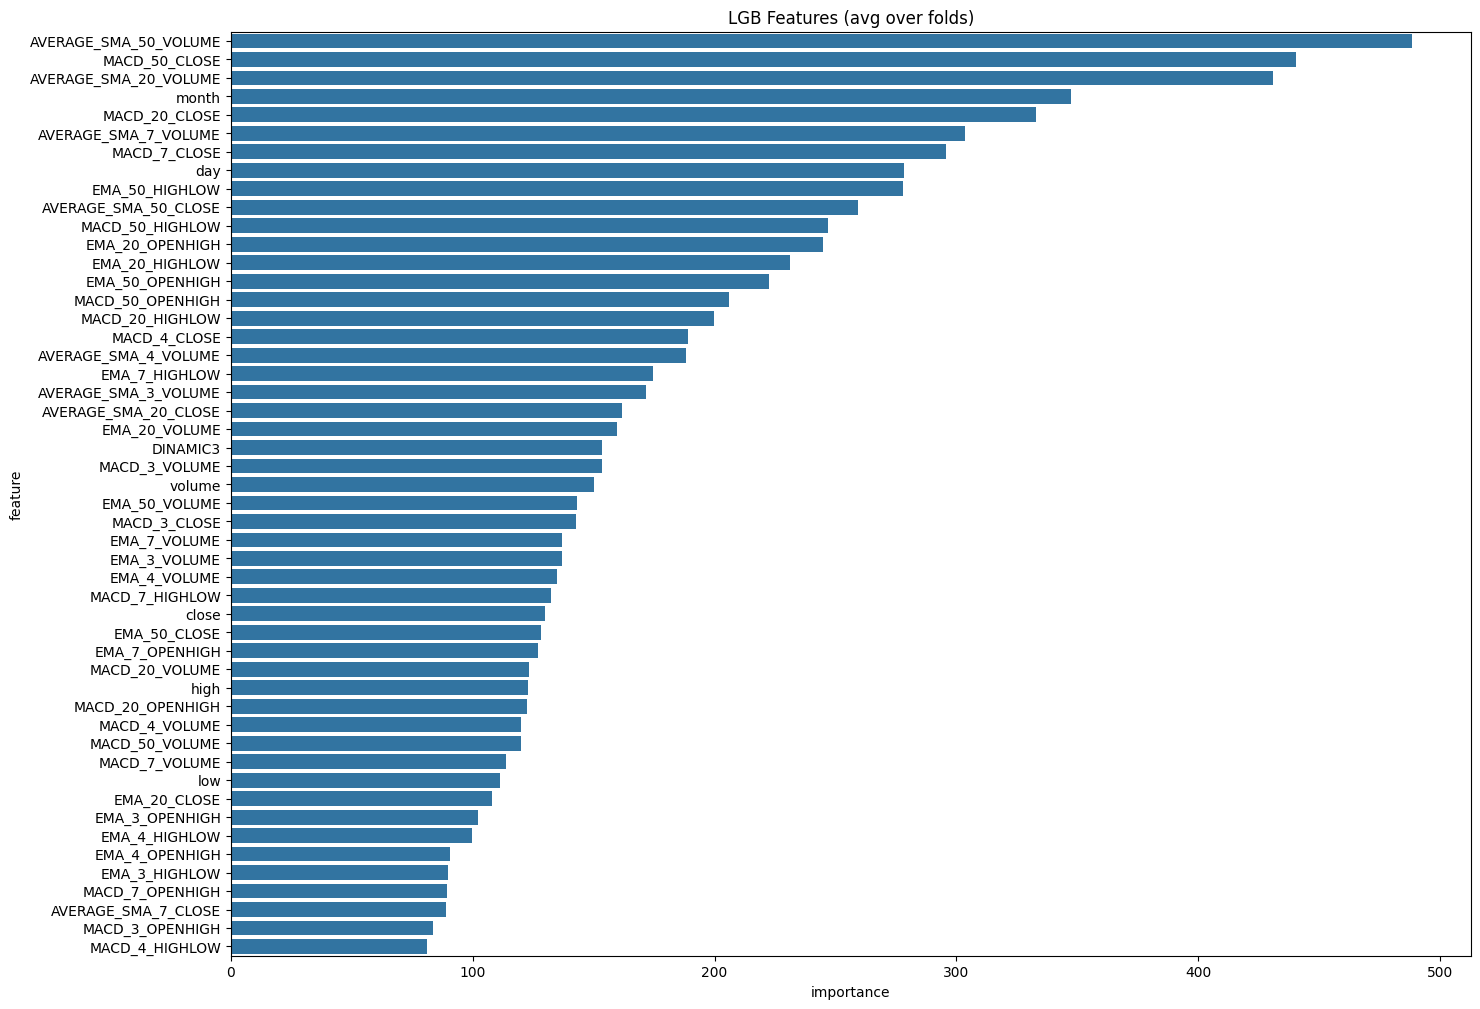

In [15]:
# Modules import - base
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import time
import math

#Modules for prediction
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold, RepeatedStratifiedKFold, cross_validate, StratifiedShuffleSplit
from sklearn import metrics

# DATA LOADING
from sklearn.neural_network import MLPClassifier

path = '/kaggle/input/stock-market-prediction/'
pathOutput = './'
fullTrain='dataset_train_validation.csv'
fullTest='dataset_test.csv'

# INPUT
train = pd.read_csv(os.path.join(path, fullTrain))
test = pd.read_csv(os.path.join(path, fullTest))

# The actual results are separated for comparison
columns =  [col for col in test.columns if col not in ['company', 'age', 'market', 'TARGET']]
submission = test[columns]
solution = test['TARGET']


# The profitability is calculated in 20 days, which is the period where the target was calculated
# Move "price" values ​​back 20 positions (FOR THE FUTURE)
test['close_20days'] = test.groupby('company')['close'].shift(-20)
train['close_20days'] = train.groupby('company')['close'].shift(-20)

# Calculate profitability in 20 days (target objective)
def calculate_rent_percentage(row):
    if row['close_20days'] is not None and row['close'] is not None:
        return (100*(row['close_20days'] - row['close']))/row['close']
    else:
        return None

# Generation of the income column
test['rent_20days'] = test.apply(calculate_rent_percentage, axis=1)
train['rent_20days'] = train.apply(calculate_rent_percentage, axis=1)



# DELETING rows with null in the TARGET column
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

train = filter_rows_by_values(train, "TARGET", ["null"])

# NEW FEATURES
# 33 RSI
def relative_strength_idx(df, n=14):
    close = df['close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

# NEW FEATURES TRAIN
train['close_lag'] = train['close'].shift(1)
train['RSI'] = relative_strength_idx(train).fillna(0)
train = train.fillna(0)

# NEW FEATURES TEST
# all the same for the test data
test['close_lag'] = test['close'].shift(1)
test['RSI'] = relative_strength_idx(test).fillna(0)
test = test.fillna(0)

#---------------------------------------------------------
# The train data is divided into: train + validation
fraction_train = 0.7  # Fraction of data used for training
fraction_valid = 1.00 - fraction_train
train_random = train.sample(frac=1)
train = train_random.iloc[:int(fraction_train * len(train)), :]
validation = train_random.iloc[int(fraction_train * len(train)):, :]

# It is separated into features and target
train_X = train[columns]
train_y = train['TARGET']
valid_X = validation[columns]
valid_y = validation['TARGET']

# MODEL TRAINING
# MODEL LGBM(Light Gradient Boosting Machine)
folds = GroupKFold(n_splits=5)
params = {'objective': 'binary',
          'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "metric": 'precision',
          'n_jobs': -1,
          'min_data_in_leaf': 32,
          'num_leaves': 1024,
          }
for fold_n, (train_index, valid_index) in enumerate(folds.split(train_X, train_y, groups=train['company'])):
    print(f'Fold {fold_n} started at {time.ctime()}')
    X_train, X_valid = train_X[columns].iloc[train_index], train_X[columns].iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]

    model = lgb.LGBMClassifier(**params, n_estimators=50)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)])
#--------------------------------------------------------------------------

# FEATURES ARE DRAWN BY IMPORTANCE
feature_importance = pd.DataFrame()
fold_importance = pd.DataFrame()
fold_importance["feature"] = columns
fold_importance["importance"] = model.feature_importances_
fold_importance["fold"] = fold_n + 1
feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

feature_importance["importance"] /= 5
# The first 50 features are printed
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');
# plt.show(block=False)
# plt.pause(5)
plt.savefig(pathOutput + "BAG_feature_importances.png")
# plt.close()

# VALIDATION
print("BEGINNING OF VALIDATION")
score = metrics.mean_absolute_error(valid_y, model.predict(valid_X))
print('CV score: {0:.4f}.'.format(score))
print("END OF VALIDATION")
#-----------------------------------------------------------------------


*This code deals with evaluating the performance and profitability of a model that predicts whether an item will be rented or not*

In [14]:
# Independent PREDICTION

# Removing rows to null
test = filter_rows_by_values(test, "TARGET", ["null"])

submission = test[columns]
solution = test['TARGET']

# Only applicable if there is sigmoid in the last layer
prediction = (model.predict(submission) > 0.5).astype("int32")
submission['TARGET']=prediction

# The company is added in the first column and saved in Excel
submission=submission.join(test['company'])
submission.set_index(submission.pop('company'), inplace=True)
submission.reset_index(inplace=True)
submission.to_csv(os.path.join(pathOutput, 'BAG_feature_importances.csv'), index=False)

# Independent PRECISION
a=solution
b=prediction
TP=sum(1 for x,y in zip(a,b) if (x == y and y == 1))
TPandFP=sum(b)
precision= TP / TPandFP
print("TP: ", TP)
print("TP + FP: ", TPandFP)
print("---->>>>>> PRECISION (TP/(TP+FP)) FOR TEST DATASET: {0:.2f}% <<<<<<------".format(precision * 100))

# Imbalance rate
ift_majority = test[test.TARGET == False]
ift_minority = test[test.TARGET == True]
rateImbalance = round(ift_majority.shape[0] / ift_minority.shape[0], 2)
print("Imbalance rate = " + str(ift_majority.shape[0]) + "/" + str(
        ift_minority.shape[0]) + " = " + str(rateImbalance))

print("Handle precision improvement over random: ",
              round(precision / (1/(1+rateImbalance)), 2))

from sklearn.metrics import classification_report
print("Metrics report:")
print(classification_report(a, b))

#--------------------------------------------------------------------------------
# Returns
print("PROFITABILITY. They look at each other one by one, without accumulating:")

full_income=test['rent_20days']
valuerentabase=sum(full_income)/len(full_income)
print("Average return of the full test set, unfiltered: ", valuerentabase)

# Income selection of only items where you would invest
a=test['rent_20days']
b=prediction
probabilities_added_to_investing = sum(x for x,y in zip(a,b) if (y == 1))
numberinvestments= sum(b)
valuerentalinvest= probabilities_added_to_investing / numberinvestments

print("Average profitability of the test set where to invest, with filter: ", valuerentalinvest)


# TRAINING solution rental
b=train
b=b.loc[b['TARGET'] == 1]
added_probabilities=sum(b['rent_20days'])
numberinvestments= len(b)
rental_solution= added_probabilities / numberinvestments

print("Average profitability of the solution set (TRAIN): ", rental_solution)


print("END")

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


<ipython-input-14-3d44d81931c1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['TARGET']=prediction


TP:  88
TP + FP:  124
---->>>>>> PRECISION (TP/(TP+FP)) FOR TEST DATASET: 70.97% <<<<<<------
Imbalance rate = 93534/4658 = 20.08
Handle precision improvement over random:  14.96
Metrics report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98     93534
         1.0       0.71      0.02      0.04      4658

    accuracy                           0.95     98192
   macro avg       0.83      0.51      0.51     98192
weighted avg       0.94      0.95      0.93     98192

PROFITABILITY. They look at each other one by one, without accumulating:
Average return of the full test set, unfiltered:  3.23010036552872
Average profitability of the test set where to invest, with filter:  23.190522979511474
Average profitability of the solution set (TRAIN):  3.12876840084734
END
